In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Proj, Transformer
import icp
import csv

In [2]:
import rosbag
from sensor_msgs.msg import NavSatFix
from nav_msgs.msg import Odometry
import math

In [3]:
# Rosbag containing two topics from driving around in the CARLA simulator
# on a custom map.
# /navsat/odom: X Y points produced by CARLA in meters.
# /carla/ego_vehicle/gnss/gnss1/fix: Lat Long coordinates produced by CARLA
bag = rosbag.Bag('odom_gnss_2.bag')

In [4]:
odom = {"x": np.array([], dtype='float64'), "y": np.array([], dtype='float64')}
gnss = {"latitude": np.array([], dtype='float64'), "longitude": np.array([], dtype='float64')}
for topic, msg, t in bag.read_messages('/navsat/odom'):
    odom['x'] = np.append(odom['x'], [msg.pose.pose.position.x])
    odom['y'] = np.append(odom['y'], [msg.pose.pose.position.y])
    
for topic, msg, t in bag.read_messages('/carla/ego_vehicle/gnss/gnss1/fix'):
    gnss['latitude'] = np.append(gnss['latitude'], [msg.latitude])
    gnss['longitude'] = np.append(gnss['longitude'], [msg.longitude])


# ODOM vs GNSS data from CARLA

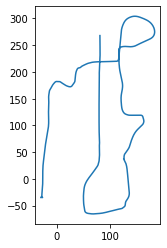

In [5]:
# Plot XY data
plt.plot(odom['x'],odom['y'])
plt.gca().set_aspect('equal', adjustable='box')

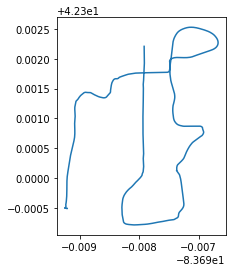

In [6]:
# Plot lat long data
plt.plot(gnss['longitude'],gnss['latitude'])
plt.gca().set_aspect('equal', adjustable='box')

lat_r = (min(gnss['latitude']), max(gnss['latitude']))
lon_r = (min(gnss['longitude']), max(gnss['longitude']))

# CARLA GNSS Projection VS WGS84 Tests

In [7]:
# Use PyProj to project from WGS84 to UTM
def p(x, y, inverse=False):
    proj = Proj(proj='utm', ellps='WGS84', zone='17T')#Proj('EPSG:4326')
    easting, northing = proj(x, y, inverse=inverse)
    return easting, northing

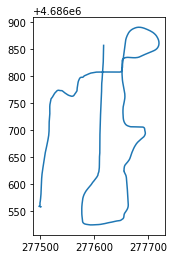

In [8]:
# Convert carla's lat long data to UTM using PyProj WGS84
easting, northing = p(gnss['longitude'],gnss['latitude'])
plt.plot(easting,northing)
plt.gca().set_aspect('equal', adjustable='box')

In [9]:
# Creating homogeneous matrices for easy projection.
odom_pts = np.vstack([odom['x'], odom['y']]).T
utm_pts = np.vstack([easting, northing]).T
utm_hom = np.ones((utm_pts.shape[0], 3))
utm_hom[:,0:2] = utm_pts

In [10]:
# Create a projection matrix to go from UTM -> CARLA

# Run ICP to find the best offset to go from UTM -> Carla
# T2, _, _ = icp.icp(utm_pts, odom_pts, rot=False)

# Use the origin position from https://git.uwaterloo.ca/WATonomous/wato_monorepo/-/blob/develop/src/path_planning/env_model/src/lanelet_service.cpp
x, y = p(-83.6989, 42.2998)
T2 = np.array([[1, 0, -x], [0, 1, -y], [0, 0, 1]])

print(T2)

[[ 1.00000000e+00  0.00000000e+00 -2.77527872e+05]
 [ 0.00000000e+00  1.00000000e+00 -4.68659132e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


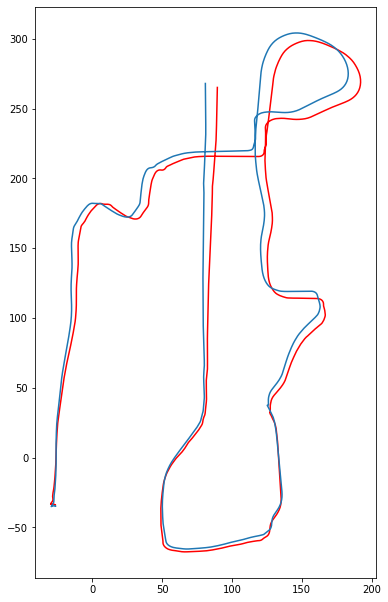

In [11]:
# Comparison of CARLA GNSS data re-projected into CARLA 
# coordinates using PyProj VS carla's raw local coordinates
# Clearly, CARLA is not using the correct WGS84 projection

utm_pts_local_hom = np.dot(T2, utm_hom.T).T
utm_pts_local = utm_pts_local_hom[:,0:2]

plt.plot(utm_pts_local_hom[:,0], utm_pts_local_hom[:,1], color="r")
plt.plot(odom['x'],odom['y'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_aspect('equal', adjustable='box')

In [12]:
# Use Iterative Closest Points (ICP) to find an affine transformation
# from our reprojected GNSS points to CARLA's XY coordinates.

T, distances, i = icp.icp(utm_pts_local, odom_pts)
print("projection:")
print(T)
print("max error", max(distances))
print(i)
t1 = T.T[2]
utm_proj = np.dot(T, utm_pts_local_hom.T).T

projection:
[[ 0.99948834 -0.03198539 -0.14416004]
 [ 0.03198539  0.99948834  0.24187068]
 [ 0.          0.          1.        ]]
max error 0.8567325501672108
11


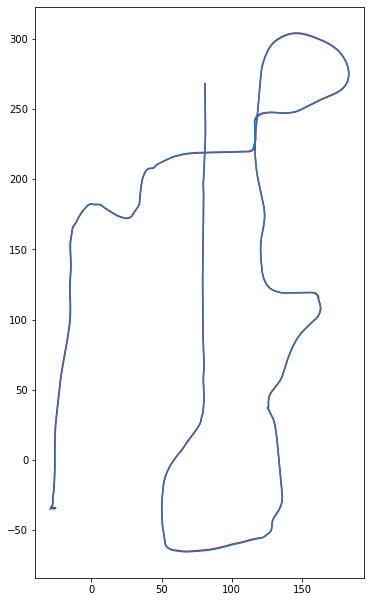

In [13]:
# Visualize the corrected data.
# Note from the print statement above, the error is still 0.8m. 
# Too high. The issue is not simply an affine transformation.

plt.plot(utm_proj[:,0], utm_proj[:,1], color="r")
plt.plot(odom['x'],odom['y'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_aspect('equal', adjustable='box')

In [14]:
# mcity_data the lat long points from the carla's XODR map of MCITY
# The XODR map was first converted to OSM

utm_wato = []

mcity_lat = []
mcity_lon = []

csv.register_dialect('skip_space', skipinitialspace=True)
with open("mcity_data", 'r') as f:
    reader=csv.reader(f , delimiter=' ', dialect='skip_space')
    for item in reader:
        lat = float(item[0])
        lon = float(item[1])
        if lat > (lat_r[0] - 0.0001) and lat < (lat_r[1] + 0.0001) and \
            lon > lon_r[0] - 0.0001 and lon < lon_r[1] + 0.0001:
                mcity_lat.append(lat)
                mcity_lon.append(lon)
print(len(mcity_lat))
print(len(mcity_lon))

108373
108373


In [15]:
# Project MCity to CARLA coordinates using PyProj WGS84
mcity_utm = np.ones((len(mcity_lat), 3))
mcity_utm[:,0:2] = np.array(p(np.array(mcity_lon),np.array(mcity_lat))).T
mcity_utm = np.dot(T2, mcity_utm.T).T[:,0:2]
#plt.scatter(mcity_lon[:1000],mcity_lat[0:1000])
#plt.gca().set_aspect('equal', adjustable='box')

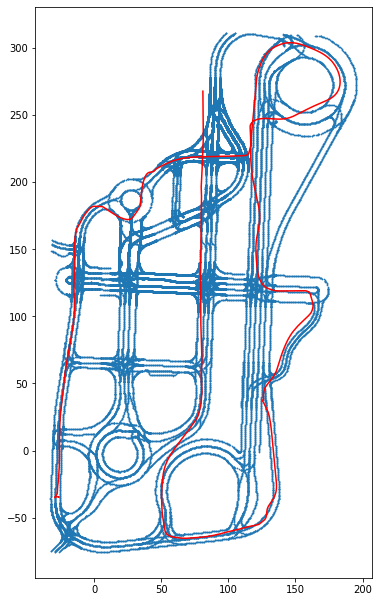

In [16]:
# Plot the carla XY data on top of MCity. 
# There's clearly a distortion here becuase I was driving 
# in the middle of the road for pretty much everything

plt.scatter(mcity_utm[:,0],mcity_utm[:,1], s=0.5)
plt.plot(odom['x'],odom['y'], color='r')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().set_aspect('equal', adjustable='box')

# CARLA Projections

In [17]:
# CARLA GeoLocation.cpp 
# https://github.com/carla-simulator/carla/blob/master/LibCarla/source/carla/geom/GeoLocation.cpp
EARTH_RADIUS_EQUA = 6378137.0

def LatToScale(lat):
    return math.cos(math.radians(lat))
        
def _LatLonToCarla(lat, lon, scale):
    mx = scale * math.radians(lon) * EARTH_RADIUS_EQUA;
    my = scale * EARTH_RADIUS_EQUA * math.log(math.tan((90.0 + lat) * math.pi / 360.0));
    return mx, my

def LatLonToCarla(lats, lons, lat_start=42.2998, lon_start=-83.6989):
    mx = []
    my = []
    scale = LatToScale(lat_start)
    startx, starty = _LatLonToCarla(lat_start, lon_start, scale);
    for lat, lon in zip(lats, lons):
        x, y = _LatLonToCarla(lat, lon, scale);
        mx.append(x - startx)
        my.append(y - starty)
    return mx, my

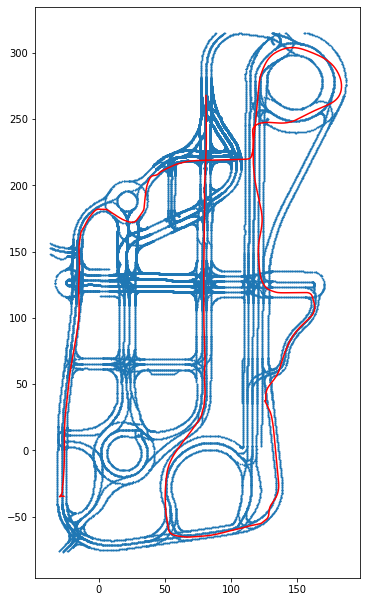

In [18]:
mcity_carla_x, mcity_carla_y = LatLonToCarla(mcity_lat, mcity_lon)
plt.scatter(mcity_carla_x, mcity_carla_y, s=0.5)
plt.plot(odom['x'],odom['y'], color='r')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().set_aspect('equal', adjustable='box')

# bunch of random stuff

In [19]:

pt = np.array([79.6, 152.8]) - T2[:2,2]
pt = p(-83.697931, 42.3011919)

In [20]:
pt + T2[:2,2] - np.array([79.6, 152.8])

array([ 5.18293342, -0.76824665])

In [21]:
 -T2[:2,2]

array([ 277527.8720243 , 4686591.32056439])

In [22]:
p( -T2[:2,2][0],  -T2[:2,2][1], inverse=True)

(-83.6989, 42.29979999999999)

In [23]:
x = np.linalg.inv(T2).dot(np.array([44.6, 215.5, 1]))
print(x)
p(x[0], x[1], inverse=True)

[2.77572472e+05 4.68680682e+06 1.00000000e+00]


(-83.6984423602101, 42.30175140638698)